In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LSTM
from tensorflow.keras import utils
import tensorflow as tf
from tensorflow import keras
import h5py   

In [13]:
classifies = ['Audi','hyundai','lexus','mazda','Mercedes','opel','toyota','volkswagen','Bu']
classifies2 = classifies[:8]    #Loại lớp bù

path = "Class/"

In [35]:
data = []
labels = []
imagePaths = []

#Kích cỡ quy định cho các tấm ảnh trong lớp phải quy về kích cỡ chung với nhau
WIDTH = 128
HEIGHT = 128

N_CHANNELS = 3      #Kênh màu, Phải có 3 kênh RGB

#1.Lưu đường dẫn của hình ảnh và chỉ số thư mục chứa nó
for index, name in enumerate(classifies):
    for file in os.listdir(path+ name):
        imagePaths.append( [path+name +'/'+file, index])

#2.>>> Quan trọng : Xáo trộn sắp xếp ngẫu nhiên lại các phân tử mảng imagePaths[]
import random
random.shuffle(imagePaths)
print(imagePaths[:10])

#3. Đọc từng ảnh, thay đổi kích cỡ ảnh và lưu trữ chỉ số ảnh
for imagePath in imagePaths:
    image = cv2.imread(imagePath[0])            #Đọc ảnh từ đường dẫn
    image = cv2.resize(image, (WIDTH,HEIGHT))  #thay đổi kích cỡ hỉnh ảnh
    data.append(image)

    #Thêm lớp nhãn từ đường dẫn hình ảnh và cập nhật danh sách
    label = int(imagePath[1])
    labels.append(label)

print('Số lượng ảnh: {0}'.format(len(data)))

[['Class/Bu/hinh (151).jpg', 8], ['Class/volkswagen/images318_rotate_90_181.jpg', 7], ['Class/Bu/hinh (1398).jpg', 8], ['Class/Mercedes/anh (798).jpg', 4], ['Class/Audi/anh (123).jpg', 0], ['Class/volkswagen/Logo-VW-Yeni_rotate_180_233.jpg', 7], ['Class/toyota/images116.jpg', 6], ['Class/toyota/images275_rotate_90_158.jpg', 6], ['Class/opel/images253.jpg', 5], ['Class/Bu/hinh (211).jpg', 8]]
Số lượng ảnh: 7969


In [38]:

data = np.array(data, dtype='float32')/255
labels = np.array(labels)
print(labels)

[8 7 8 ... 8 5 2]


Chia sẽ và huấn luyện dư liệu

In [39]:
#Chia dữ liệu ra làm 2 phần trong đó: train(70%) và test(30%)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.3, random_state=50)

In [40]:
#Trước quy trình nhãn lớp

trainY = utils.to_categorical(trainY, num_classes= len(classifies))
#trainX = np.squeeze(trainX, axis=-1)

#Nếu kích cỡ ảnh resize càng lớn thì số hình ảnh huấn luyện càng ít. Ví dụ: 2100/128(kích cỡ ảnh resize) = 16; 2100/32 = 65
#Số lượng resize càng nhỏ thì chạy càng lâu => Chưa chắc hiệu quả
#Học ít thì mấy lớp gần giống nhau thì khó phân biệt. Còn học nhiều thì bị rối
#Nếu 500 tấm hình trên mỗi đối tường thì Epoch có gía trị tầm 30-35
#Nếu 500 tấm hình trên mỗi đối tường thì Epoch có gía trị tầm 120-280

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

#Các biến quan trọng

EPOCHS = 30
INIT_LR = 1e-3
BS = 32
#----------------
class_names = classifies

(5578, 128, 128, 3)
(2391, 128, 128, 3)
(5578, 9)
(2391,)


1.Mô hình kiến trúc CNN && Chạy Thủ và đánh giá

In [41]:

model = Sequential()  #khởi tạo một mô hình tuần tự .Kiểu mô hình tuần tự cho phép thêm các lớp mạng theo thứ tự tuần tự.

model.add(Convolution2D(32, (2,2), activation='relu', input_shape=(HEIGHT, WIDTH, N_CHANNELS)))

# Lớp này thực hiện phép lấy mẫu tối đa (max pooling) trên đầu ra của lớp trước đó. Pooling giúp giảm kích thước của dữ liệu và cải thiện khả năng chống nhiễu của mô hình
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Lớp Dropout() Này ngẫu nhiên bỏ 1 tỷ lệ các nỏ-ron ra trong quá trình huấn luyện, giúp ngăn ngừ mô hình học thuộc lòng (overfitting)
model.add(Dropout(0.25))

#Flatten(): Lớp này chuyển đổi dữ liệu đầu ra từ dạng 3 chiều (chiều cao, rộng, số kênh) thành dạng 1 chiều (vector), chuẩn bị cho các lớp Dense tiếp theo.
model.add(Flatten())

#Lớp Dense(): có 128 nơ-ron và sử dụng hàm kích hoạt ReLU.
model.add(Dense(128, activation='relu'))

#Lớp Dropout(0.5) hủy bỏ 50% các nơ-ron đầu ra trong quá trình huấn luyện.
model.add(Dropout(0.5))

#Lớp Dense():có 8 nơ-ron và sử dụng hàm kích hoạt softmax để cho ra xác suất thuộc một trong 8 lớp (output classes).
model.add(Dense(len(classifies), activation='softmax'))

#biên dịch mô hình. Quá trình biên dịch xác định hàm mất mát (loss function), bộ tối ưu hóa (optimizer) và các số liệu đánh giá (metrics) được sử dụng trong quá trình huấn luyện mô hình.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 127, 127, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,936,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,942,089 (15.04 MB)

 Trainable params: 3,942,089 (15.04 MB)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
#Huấn luyện mô hình CNN
model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 52s 250ms/step - accuracy: 0.2636 - loss: 2.1910
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 56s 320ms/step - accuracy: 0.4282 - loss: 1.6178
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - accuracy: 0.5675 - loss: 1.2834
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.6467 - loss: 1.0390
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 266ms/step - accuracy: 0.7189 - loss: 0.8292
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.7868 - loss: 0.6561
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - accuracy: 0.8205 - loss: 0.5319
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.8557 - loss: 0.4402
Epoch 9/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8768 - loss: 0.3732
Epoch 10/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.8968 - loss: 0.3132
Epoch 11/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.9027 - loss: 0.2932
Epoch 12/30
175/175

2.Mô hình kiến trúc MobileNet && Chạy Thủ và đánh giá

In [49]:
from tensorflow.keras.applications import InceptionV3, MobileNet, VGG16, DenseNet121, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras import layers
from keras import models

print('[INFO] compiling model...')
inceptionv3 = InceptionV3(input_shape=(128,128,3), include_top=False, weights = 'imagenet')
for layer in inceptionv3.layers:
  layer.trainable = False

model2 = Sequential()

model2.add(inceptionv3)
model2.add(GlobalAveragePooling2D())
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(len(class_names), activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model2.summary())

[INFO] compiling model...


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

None


In [50]:
#Huấn luyện mô hình InceptionV3
model2.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 175s 849ms/step - accuracy: 0.3294 - loss: 3.0752
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 158s 904ms/step - accuracy: 0.5945 - loss: 1.5352
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 170s 975ms/step - accuracy: 0.6480 - loss: 1.2820
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 172s 799ms/step - accuracy: 0.6803 - loss: 1.1372
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 135s 771ms/step - accuracy: 0.6924 - loss: 1.0488
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 152s 869ms/step - accuracy: 0.7011 - loss: 1.0594
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 139s 793ms/step - accuracy: 0.7178 - loss: 0.9621
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 126s 719ms/step - accuracy: 0.7314 - loss: 0.9260
Epoch 9/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 125s 715ms/step - accuracy: 0.7253 - loss: 0.9609
Epoch 10/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 152s 771ms/step - accuracy: 0.7379 - loss: 0.8968
Epoch 11/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 128s 733ms/step - accuracy: 0.7454 - loss: 0.8850
Epoch 12

3.Mô hình kiến trúc Lenet && Chạy Thủ và đánh giá

4.Mô hình kiến trúc InceptionV3 && Chạy Thủ và đánh giá

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classifier_vgg16 = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')
for layer in classifier_vgg16.layers:
    layer.trainable = False

#-----------
model5 = classifier_vgg16.output
model5 = Flatten()(model5)
model5 = Dense(1024, activation='relu', name='fcl')(model5)
model5 = Dropout(0.5)(model5)
model5 = Dense(14, activation='softmax', name='prediction')(model5)
model5 = Model(inputs= classifier_vgg16.input, outputs= model5)
model5.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

print(model5.summary())

5.Mô hình kiến trúc VGG16 && Chạy Thủ và đánh giá

>> Hàm Đánh giá mô hình

In [43]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score

def DanhGia_DoChinhXac(mohinh):
    pred = mohinh.predict(testX)
    predicitions = argmax(pred, axis=1)     #trả vè nhân

    cm = confusion_matrix(testY, predicitions)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticklabels(['']+ classifies2)
    ax.set_yticklabels(['']+ classifies2)

    for i in range(3):
        for j in range(3):
            ax.text(i,j ,cm[j,i], va='center', ha='center')

    plt.title('Model confution matrix')
    plt.xlabel('predicted')
    plt.ylabel('True')
    plt.show()
    
    #Hiển thị độ chính xác của mô hình
    accuracy = accuracy_score(testY, predicitions)
    print("Accuracy: %.2f%%"%(accuracy*100.0))

2.1 Đánh gia mô hình CNN

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step


C:\Users\VTOS\AppData\Local\Temp\ipykernel_4264\3093072512.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+ classifies2)
C:\Users\VTOS\AppData\Local\Temp\ipykernel_4264\3093072512.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+ classifies2)


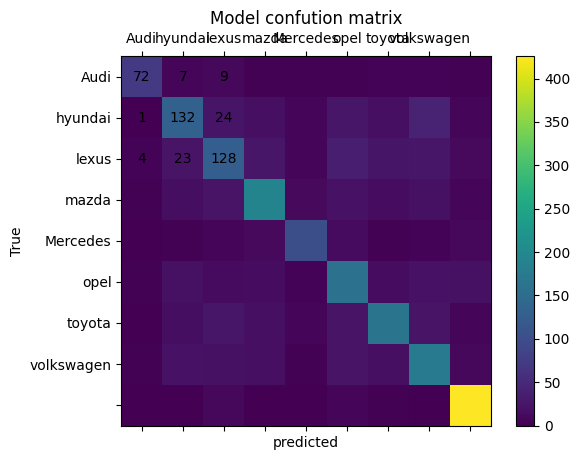

Accuracy: 64.91%


In [44]:
DanhGia_DoChinhXac(model)